In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd '/content/drive/MyDrive/CS550/SRCNN/'

/content/drive/.shortcut-targets-by-id/1oE8U0pU-coSldw8OMDE7dzHH0664tLkj/CS550/SRCNN


In [6]:
import os
import math
import sys


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from scipy.ndimage.filters import gaussian_filter

from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from helper.distort_images import distort_image
from helper.utils import ycbcr2rgb
from helper.utils import psnr
from helper.evaluate_models import evaluate_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SR_FACTOR = 3

train_pixel_mean = 0.43411854967058106
train_pixel_std = 0.23247274722791464

In [7]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4);
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0);
        self.conv3 = nn.Conv2d(32, 1, kernel_size=7, padding=3);

    def forward(self, img):
        out = F.relu(self.conv1(img)) #n_1=64 feature maps
        out = F.relu(self.conv2(out)) #non linear mapping
        out = self.conv3(out)
        return out
print(torch.cuda.is_available())

True


In [8]:
SR_model = SRCNN().to(device)
SR_model.load_state_dict(torch.load('./checkpoint/test_checkpoint_SRCNN_w_MSE.pt' , map_location='cpu')['model_state_dict'])

<All keys matched successfully>

In [9]:
summary(SR_model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           5,248
            Conv2d-2           [-1, 32, 32, 32]           2,080
            Conv2d-3            [-1, 1, 32, 32]           1,569
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.76
Params size (MB): 0.03
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


In [10]:
SR_model

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)

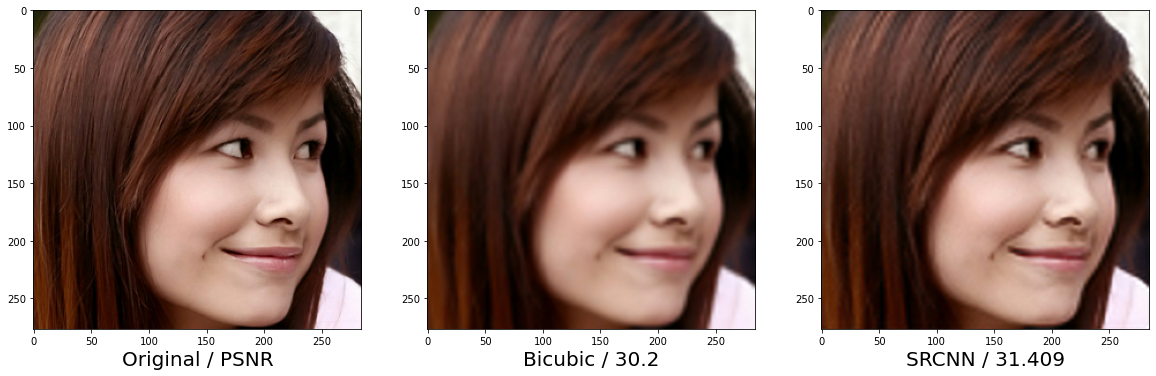

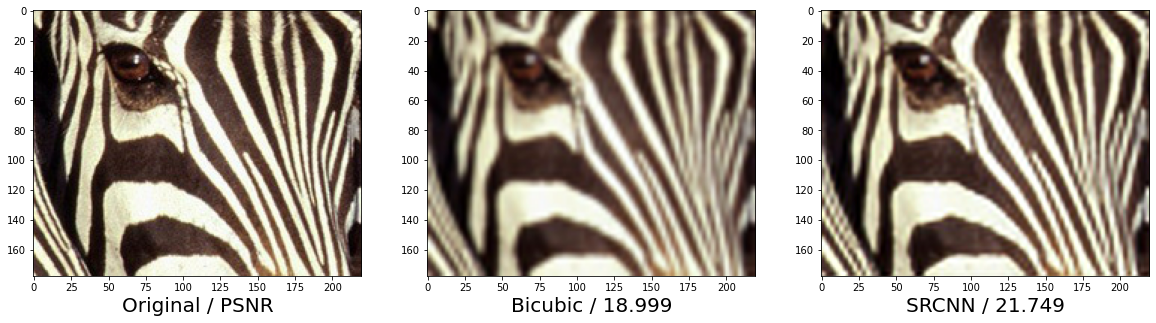

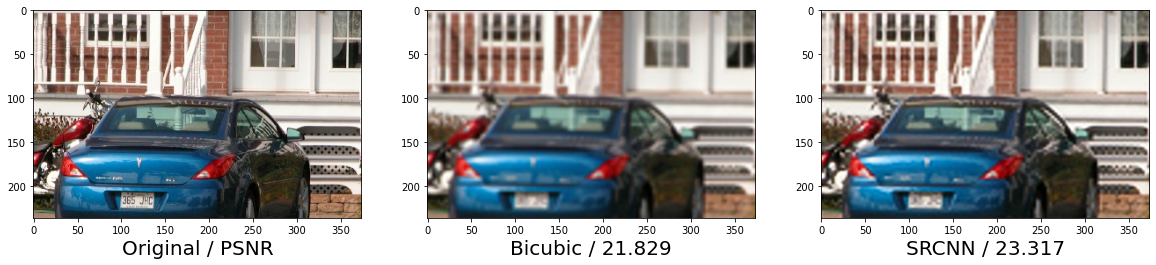

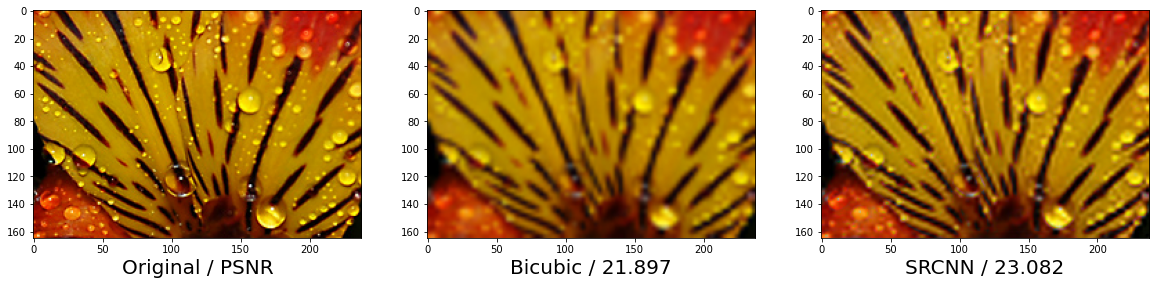

In [11]:
SR_model.conv1.padding = (4,4)
SR_model.conv3.padding = (3,3)
test5_img_names = [im for im in os.listdir('./data/evaluate') if im[-4:] == '.bmp']

for test_im in test5_img_names:
    path = './data/evaluate/' + test_im
    blurred_test_im = distort_image(path=path, factor=SR_FACTOR, sigma=1, blur=True)
    ImageFile = Image.open(path)
    im = np.array(ImageFile.convert('YCbCr')) 
    
    #normalize
    input = blurred_test_im[:,:,0] / 255.0
    #standardize
    input -= train_pixel_mean
    input /= train_pixel_std
    im_out_Y = SR_model(torch.tensor(input, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device))
    im_out_Y = im_out_Y.detach().squeeze().squeeze().cpu().numpy().astype(np.float)
    im_out_viz = np.zeros((im_out_Y.shape[0], im_out_Y.shape[1], 3))
    
    #unstandardize 
    im_out_Y = (im_out_Y * train_pixel_std) + train_pixel_mean
    
    #un-normalize
    im_out_Y *= 255.0

    im_out_viz[:,:,0] = im_out_Y
    im_out_viz[:,:,1] = im[:,:,1]
    im_out_viz[:,:,2] = im[:,:,2]


    f, axarr = plt.subplots(1,3, figsize=(20, 20))
    axarr[0].set_xlabel('Original / PSNR', fontsize=20)
    axarr[0].imshow(Image.fromarray(im, 'YCbCr'))

    axarr[1].set_xlabel('Bicubic / ' + str(np.around(psnr(im[:,:,0], blurred_test_im[:,:,0]),3)), fontsize=20)
    axarr[1].imshow(Image.fromarray(blurred_test_im, 'YCbCr'))
    
    axarr[2].set_xlabel('SRCNN / ' + str(np.around(psnr(im[:,:,0], im_out_viz[:,:,0]),3)), fontsize=20)
    axarr[2].imshow(ycbcr2rgb(im_out_viz))